In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
from scipy import stats
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
import networkx as nx
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

C:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Получение и обработка данных

In [2]:
df = pd.read_csv(r'ci_data_internship.csv', sep=',', encoding = 'cp1251', quoting=3)
df.index=[x[1] for x in df.index]
# извлечение численного значения (предположительно номера почтового индекса) из адреса 
df.loc[df['Unnamed: 0'].notna(),'Unnamed: 0']=df[df['Unnamed: 0'].notna()]['Unnamed: 0'].apply(lambda x: re.search('""(.+?) ', str(x)).group(1))
# избавление от кавычек
df.loc[df.S_sales.notna(),'S_sales']=df[df.S_sales.notna()].S_sales.apply(lambda x: str(x)[:-1])
# приведение данных типа object к float64 
df.S_sales = df.S_sales.replace('',np.nan).astype('float64')
df.id = df.index
df.address = df['Unnamed: 0'].astype('float64')
df.drop(columns='Unnamed: 0', inplace=True)
df.reset_index(inplace=True, drop=True)
df

,id,address,is_holiday,day_type,season,comp_activity,M_promo_exp,M_promo_internet,M_promo_banners,S_price,M_price,menu_type,average_purchase_items,average_paycheck,repeated_customers_number,customers_number,M_sales,S_sales
0,10111423.0,7435.0,0.0,1.0,3.0,0.0,NaN,0.0,0.0,279.0,NaN,1.0,1.397272,1149.887204,3.0,278.0,0.000000,325.649802
1,10111423.0,7435.0,0.0,1.0,3.0,0.0,0.00000,0.0,0.0,279.0,0.0,1.0,1.406686,990.536338,4.0,297.0,0.000000,363.303956
2,10111423.0,7435.0,0.0,0.0,3.0,0.0,0.00000,0.0,0.0,279.0,0.0,1.0,1.387417,1030.467712,7.0,289.0,0.000000,381.740162
3,10111423.0,7435.0,0.0,0.0,3.0,0.0,0.00000,0.0,0.0,279.0,0.0,1.0,1.503351,1069.963783,8.0,291.0,0.000000,362.562682
4,10111423.0,7435.0,0.0,0.0,3.0,0.0,0.00000,0.0,0.0,279.0,0.0,1.0,1.542436,931.799035,8.0,297.0,0.000000,369.368186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,10112422.0,11522.0,0.0,0.0,4.0,0.0,26178.53131,28.0,4.0,349.0,389.0,7.0,2.425469,1082.431184,8.0,295.0,449.496303,196.547464
539996,10112422.0,11522.0,0.0,0.0,4.0,0.0,26178.53131,28.0,4.0,349.0,389.0,7.0,2.139832,1008.093500,8.0,301.0,364.309695,261.682503
539997,10112422.0,11522.0,NaN,0.0,4.0,0.0,26178.53131,28.0,4.0,349.0,389.0,7.0,2.156813,1121.088933,9.0,305.0,393.464166,238.297711
539998,10112422.0,11522.0,0.0,0.0,4.0,0.0,NaN,28.0,4.0,349.0,389.0,7.0,2.215092,1009.436042,7.0,282.0,395.165902,209.090093


Устранение пропусков в данных

In [3]:
df.isna().sum()

id                           26879
address                      26847
is_holiday                   26872
day_type                     26939
season                       26960
comp_activity                26967
M_promo_exp                  27099
M_promo_internet             26982
M_promo_banners              27031
S_price                      27003
M_price                      27023
menu_type                    26756
average_purchase_items       26822
average_paycheck             27081
repeated_customers_number    26916
customers_number             26961
M_sales                      52673
S_sales                      52278
dtype: int64

In [4]:
# т.к. id кафе однозначно определяет его адрес и наоборот, то можно устранить часть пропусков медианой 
df.loc[:,'address']=df['address'].fillna(df.groupby('id')['address'].transform('median'))
df.loc[:,'id']=df['id'].fillna(df.groupby('address')['id'].transform('median'))
# те данные, где пропущены и id, и адрес восстановить не получится, поэтому избавимся от них
df=df[~df.id.isna()]
# т.к. строки датафрейма - это промежутки времени, то пропуски в части данных можно заменить на предыдущие/последующие значения
df.loc[:,'is_holiday']=df['is_holiday'].bfill()
df.loc[:,'day_type']=df['day_type'].bfill()
df.loc[:,'season']=df['season'].bfill()
df.loc[:,'comp_activity']=df['comp_activity'].bfill()
df.loc[:,'M_promo_exp']=df['M_promo_exp'].bfill()
df.loc[:,'M_promo_internet']=df['M_promo_internet'].bfill()
df.loc[:,'M_promo_banners']=df['M_promo_banners'].bfill()
df.loc[:,'S_price']=df['S_price'].bfill()
df.loc[:,'M_price']=df['M_price'].bfill()
df.loc[:,'menu_type']=df['menu_type'].bfill()
# некоторые данные из логических соображений зависят от совокупности факторов, поэтому пропуски в них можно заменить, на средние по группам
df.loc[:,'average_purchase_items']=df['average_purchase_items'].fillna(df.groupby(['id','is_holiday','day_type','season'])['average_purchase_items'].transform('mean'))
df.loc[:,'average_paycheck']=df['average_paycheck'].fillna(df.groupby(['id','is_holiday','day_type','season'])['average_paycheck'].transform('mean'))
df.loc[:,'repeated_customers_number']=df['repeated_customers_number'].ffill()
df.loc[:,'customers_number']=df['customers_number'].fillna(df.groupby(['id','is_holiday','day_type','season'])['customers_number'].transform('mean'))
df.loc[:,'M_sales']=df['M_sales'].fillna(df.groupby(['id','is_holiday','day_type','season'])['M_sales'].transform('mean'))
df.loc[:,'S_sales']=df['S_sales'].fillna(df.groupby(['id','is_holiday','day_type','season'])['S_sales'].transform('mean'))
# замена оставшихся пропусков в данных интерполяцией
df.loc[:,'average_purchase_items']=df['average_purchase_items'].fillna(df['average_purchase_items'].interpolate(method='polynomial',order=2))
df.loc[:,'average_paycheck']=df['average_paycheck'].fillna(df['average_paycheck'].interpolate(method='polynomial',order=2))
df.loc[:,'customers_number']=df['customers_number'].fillna(df['customers_number'].interpolate(method='polynomial',order=2))
df.loc[:,'M_sales']=df['M_sales'].fillna(df['M_sales'].interpolate(method='polynomial',order=2))
df.loc[:,'S_sales']=df['S_sales'].fillna(df['S_sales'].interpolate(method='polynomial',order=2))

In [5]:
df.isna().sum()

id                           0
address                      0
is_holiday                   0
day_type                     0
season                       0
comp_activity                0
M_promo_exp                  0
M_promo_internet             0
M_promo_banners              0
S_price                      0
M_price                      0
menu_type                    0
average_purchase_items       0
average_paycheck             0
repeated_customers_number    0
customers_number             0
M_sales                      0
S_sales                      0
dtype: int64

Избавление от выбросов

In [6]:
df.season.unique()

array([3.00000000e+00, 0.00000000e+00, 4.00000000e+00, 1.00000000e+00,
       6.83971682e+04, 4.10285962e+04, 2.00000000e+00, 2.61785313e+04,
       3.62483616e+04, 1.01934330e+05])

In [7]:
df=df[df.season<=4]

In [8]:
df.menu_type.unique()

array([1.00000000e+00, 1.05505348e+03, 8.99746094e+02, ...,
       1.03934224e+03, 9.76634967e+02, 9.08568850e+02])

In [9]:
df=df[df.menu_type<=10]
df.reset_index(inplace=True, drop=True)

In [10]:
df.loc[((df.M_sales<50)&(df.M_price<10))].M_sales.unique()

array([ 0.00000000e+00, -4.55959586e+01, -3.79085716e+01, -1.04475263e-06,
        1.00629081e-08, -4.21741965e-05, -5.04413114e+01, -8.59648044e-02,
        1.29126443e-02, -1.20032196e-06, -2.93854923e-05, -3.24092262e-05,
        2.14347188e-01, -2.29962302e-03,  2.20584127e-04, -1.14581691e-03,
       -7.54015237e-16,  2.43819824e-06, -4.20742687e-02, -8.42802720e-07,
        2.27001026e-12,  7.23373467e+00,  1.21541347e-05,  9.37926820e-37,
        8.89492640e+00,  6.55190164e+00, -3.26065617e-08,  4.00411618e-06,
       -7.91010153e-02, -2.52875021e-11,  4.15595585e-12,  9.40278552e-09,
        1.84873431e+01,  7.40967940e-03,  1.86120172e-04, -1.84778834e+01,
        1.17278879e-05, -1.48608805e-05,  4.29439160e-03, -1.95644628e-03,
       -1.26456598e+00,  1.98627899e-04, -4.27254201e+01,  1.32284903e-05,
        9.02243342e+00, -5.39208953e+01, -1.31471469e+00, -5.17539078e+01,
       -1.08644855e-03, -2.48864955e-08,  5.71297718e-12,  8.70145604e+00,
        2.15112235e-01, -

In [11]:
df.loc[((df.M_sales<50)&(df.M_price<10)),'M_sales'] = 0.0

# Причинно-следственный анализ

## 1. Проверка причинно-следственной связи между переменными S_sales и M_sales

Проверим корреляцию между S_sales и M_sales, начиная с того момента, как новый напиток M был введён в ассортимент

Text(0.5, 1.0, 'Sales distribution')

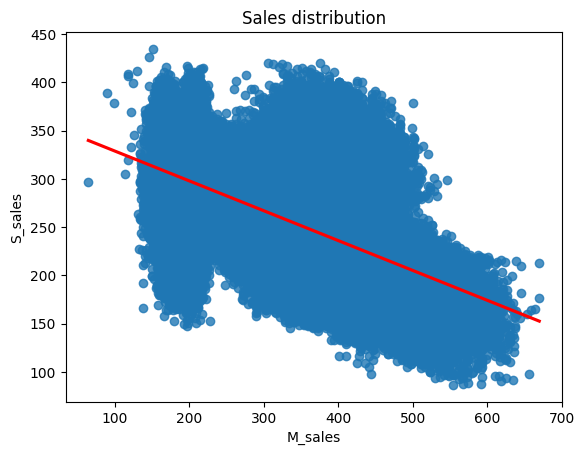

In [12]:
M_sales_after = list(df[df.M_sales > 0].M_sales)
S_sales_after = list(df[df.M_sales > 0].S_sales)
#plt.scatter(M_sales_after, S_sales_after)

#plt.gca().set_aspect('equal')
sns.regplot(x=df[df.M_sales > 0].M_sales, y=df[df.M_sales > 0].S_sales, ci=None, line_kws=dict(color="r")) 
plt.xlabel('M_sales')
plt.ylabel('S_sales')
plt.title('Sales distribution')
#plt.show()

По графику можем наблюдать наличие отрицательной корреляции. Иными словами, увеличение продаж напитка M отрицательно сказывается на продажах напитка S

Проверим, есть ли связь между M_sales и S_sales посредством корреляции Пирсона

In [13]:
ds = pd.DataFrame({'M_sales': M_sales_after, 'S_sales': S_sales_after})
pg.partial_corr(data=ds, x='M_sales', y='S_sales', covar=[], method='pearson')

,n,r,CI95%,p-val
pearson,375756,-0.554591,"[-0.56, -0.55]",0.0


Тест вернул значение p-value, меньшее 0.05, поэтому мы отвергаем нулевую гипотезу о независимости M_sales и S_sales, т.е. M_sales $\not \!\perp\!\!\!\perp$ S_sales

Проверим наше утверждение, сравнив наблюдаемое и пост-интервенционное распределения переменной S_sales. В качестве наблюдаемого будем считать распределение S_sales до введения напитка M в ассортимент, а в качестве пост-интервенционного - распределение S_sales после введения напитка M в ассортимент

Text(0.5, 1.0, 'Observed distribution')

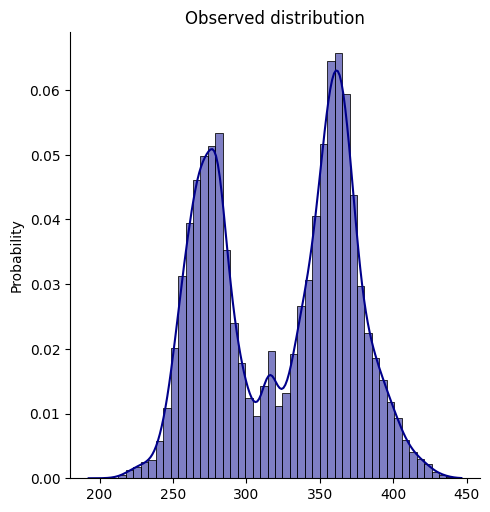

In [14]:
S_sales_before = list(df[df.M_sales == 0].S_sales)
sns.displot(S_sales_before, kde=True, stat='probability',
             bins=50, color = 'darkblue')
plt.title('Observed distribution')

Text(0.5, 1.0, 'Post-intervention distribution')

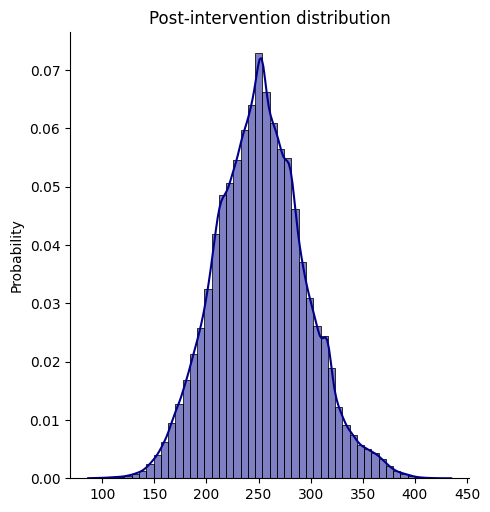

In [15]:
sns.displot(S_sales_after, kde=True, stat='probability',
             bins=50, color = 'darkblue')
plt.title('Post-intervention distribution')

Видим, что наблюдаемое бимодальное распределение заметно отличается от унимодального пост-интервенционного, удостоверимся в этом, сравнив распределения, используя тест Колмогорова-Смирнова

In [16]:
stats.ks_2samp(S_sales_before, S_sales_after)

KstestResult(statistic=0.5041838296640158, pvalue=0.0, statistic_location=265.0453853, statistic_sign=-1)

По результатам теста значение p-value меньше 0.05, значит нулевая гипотеза о том, что два распределения идентичны, отвергается, а значит, введение нового напитка M в ассортимент влияет на продажи напитка S

## 2. Восстановление максимального количества аутентичных причинно-следственных связей между переменными

Объявление необходимых для работы функций и переменных

In [17]:
# визуализация
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    
def draw_graph(G, pos):
    colors = ['red' if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]

    pos_nodes = nudge(pos, 0.0, -0.5)

    fig, ax = plt.subplots(1, figsize=(12,12))
    ax.margins(0.2)
    nx.draw(G, ax=ax, pos=pos, with_labels=False, node_size=500, node_color='w', edgecolors='black', edge_color=colors)
    nx.draw_networkx_labels(G, ax=ax, pos=pos_nodes, font_size=12)
    
# укладка графа
pos = {'id':(1,2), 'address':(1.5,4), 'is_holiday':(7, 12), 'day_type':(13, 4), 'season':(2, 7), 'comp_activity':(2.5, 12),
       'M_promo_exp':(7, 1), 'M_promo_internet':(3.5, 2.5), 'M_promo_banners':(2, 5.1), 'S_price':(5, 12), 'M_price':(9.5, 3), 'menu_type':(7.2,5.5), 
       'average_purchase_items':(7, 8),'average_paycheck':(1, 10),'repeated_customers_number':(12.2,7.2), 'customers_number':(11.3, 2.5), 
       'M_sales':(11, 9), 'S_sales':(9.5, 10.5)}
#вершины
nodes = list(df.columns)

alpha=0.05

В качестве алгоритма был выбран PC

In [18]:
graph_pc_raw = pc(df.values, alpha=alpha, indep_test='fisherz')

Depth=8, working on node 17: 100%|██████████| 18/18 [00:00<00:00, 321.42it/s]


In [19]:
graph_pc_raw.to_nx_graph()

mapping = {node:i for node, i in enumerate(df.columns)}
mapping_r = {i:node for node, i in enumerate(df.columns)}

# добавим корректные названия вершин в граф
graph_pc = nx.relabel_nodes(graph_pc_raw.nx_graph, mapping)

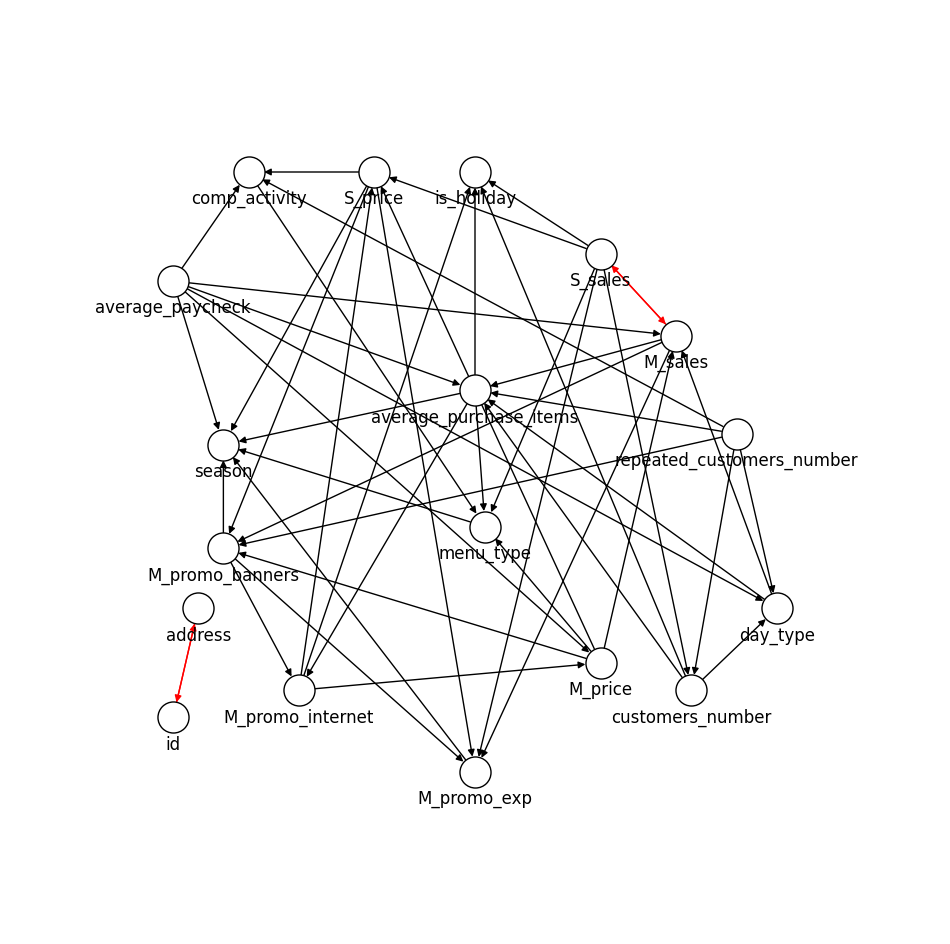

In [20]:
draw_graph(graph_pc, pos)

Неориентированными остались рёбра ('S_sales', 'M_sales') и ('id', 'address'). В первом случае можем выбрать только стрелку 'M_sales' -> 'S_sales', т.к. она не порождает новых циклов и v-структур, в то время как ориентация в обратном направлении приводит к возникновению новых  v-структур, например: 'S_sales' -> 'M_sales' <- 'average_paycheck'.

In [21]:
backgroung_knowledge = BackgroundKnowledge()
# достаем вершины из GeneralGraph
nodes = graph_pc_raw.G.get_nodes()

# удаляем возможность построить ребро в одном направлении
node_from = nodes[mapping_r['S_sales']]
node_to = nodes[mapping_r['M_sales']]

# добавляем запрет на ребро аргумент_1 -> аргумент_2
backgroung_knowledge.add_forbidden_by_node(node_from, node_to)

# полностью удаляем ребро из графа
node_from = nodes[mapping_r['id']]
node_to = nodes[mapping_r['address']]

backgroung_knowledge.add_forbidden_by_node(node_from, node_to)
backgroung_knowledge.add_forbidden_by_node(node_to, node_from)

# строим граф с учётом внесённых изменений
graph_pc_raw_bk = pc(df.values, alpha=alpha, indep_test='fisherz', background_knowledge=backgroung_knowledge)

graph_pc_raw_bk.to_nx_graph()

# добавим корректные названия вершин в граф
graph_pc_bk = nx.relabel_nodes(graph_pc_raw_bk.nx_graph, mapping)

Depth=8, working on node 17: 100%|██████████| 18/18 [00:00<00:00, 300.00it/s]


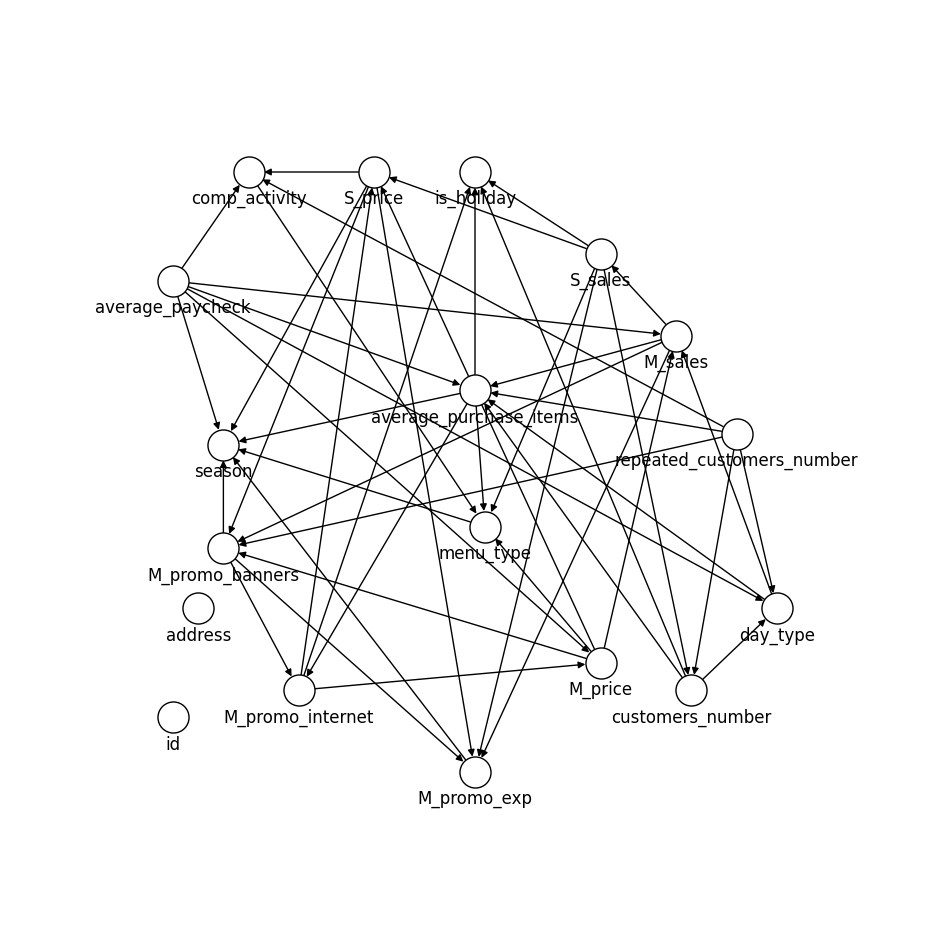

In [22]:
draw_graph(graph_pc_bk, pos)

Находить направление ребра ('id', 'address') не имеет смысла, т.к. обе эти вершины больше не имеют связей, кроме как друг с другом и выполняют, впрочем, одну и ту же функцию - однозначно идентифицируют кафе, однако, следует сказать, что на самом деле, если бы переменную address удалось преобразовать из категориальной в количественную, связав, например, адрес кафе с его удалённостью от жилых комплексов, то это, вероятно, повлияло бы на вид графа

## 3. Улучшение результата

### Устранение дисбаланса классов

Убираем ситуацию, когда одному адресу принадлежат несколько кафе и наоборот, а также, буем рассматривать только ту часть выборки, в которой уже произошло внедрение напитка M

In [23]:
df=df[df.id == df.groupby('address')['id'].transform(lambda x: x.mode()[0])]
df=df[df.M_sales > 0]

In [24]:
df.groupby('season').count()['id']

season
0.0        5
1.0    29926
2.0    40046
3.0    30891
4.0    31650
Name: id, dtype: int64

Видим, что 0-й сезон почти не встречается, поэтому проще от него избавиться

In [25]:
df=df[df.season!=0]

Сделаем так, чтобы все кафе встречались в выборке одинаковое количество раз

In [26]:
df = df.sort_values(by=['address'])
min=df.groupby('address')['address'].count().min()
for i in df.address.unique():
    while df[df['address']==i].address.count() > min:
        df=df.drop(index=df[df['address']==i].sample(n=1).index)

In [27]:
ds=df.copy()

Преобразуем переменную is_holiday в двоичную, где 1 принимают праздники, а 0 - будни

In [28]:
ds.loc[:,'is_holiday'] = np.where(ds['is_holiday'] >= 1, 1, 0)

In [29]:
ds.groupby('menu_type').count()['id']

menu_type
1.0      811
2.0      853
3.0     8919
4.0    34070
5.0    17048
6.0    25512
7.0    25713
Name: id, dtype: int64

Выполним андерсемплинг до количества элементов 3-го класса в выборке и избавимся от 1-го и 2-го типов меню

In [30]:
ds_3 = ds[ds['menu_type']==3]
ds_4 = resample(ds[ds['menu_type']==4], replace = False, n_samples = len(ds_3), random_state = 0)
ds_5 = resample(ds[ds['menu_type']==5], replace = False, n_samples = len(ds_3), random_state = 0)
ds_6 = resample(ds[ds['menu_type']==6], replace = False, n_samples = len(ds_3), random_state = 0)
ds_7 = resample(ds[ds['menu_type']==7], replace = False, n_samples = len(ds_3), random_state = 0)
ds = pd.concat([ds_3,ds_4,ds_5,ds_6,ds_7])
ds = ds.sort_values(by=['id'])

In [31]:
ds.groupby('season').count()['id']

season
1.0    12901
2.0    13424
3.0     8924
4.0     9346
Name: id, dtype: int64

Проделаем те же манипуляции с переменной season

In [32]:
ds_3 = ds[ds['season']==3]
ds_1 = resample(ds[ds['season']==1], replace = False, n_samples = len(ds_3), random_state = 0)
ds_2 = resample(ds[ds['season']==2], replace = False, n_samples = len(ds_3), random_state = 0)
ds_4 = resample(ds[ds['season']==4], replace = False, n_samples = len(ds_3), random_state = 0)
ds = pd.concat([ds_3,ds_1,ds_2,ds_4])
ds = ds.sort_values(by=['id'])

### Приведение номинальных переменных к частотам

Посмотрим на распределение количества посетителей

<Axes: xlabel='customers_number', ylabel='Count'>

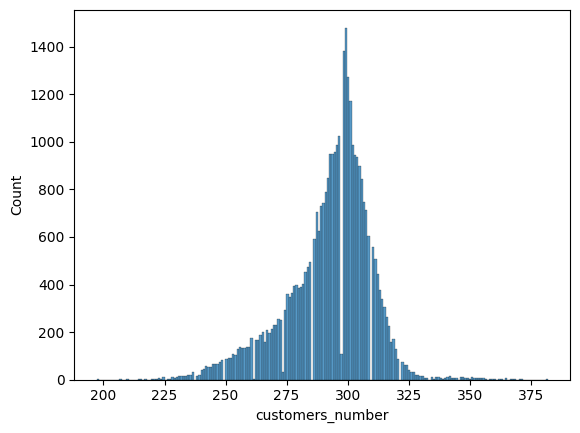

In [33]:
sns.histplot(data=ds, x="customers_number", bins=200)

Положив, что адрес кафе связан с количеством посетителей, заменим категориальные значения адреса на частоты повторения в правой половине распределения, т.е. вместо адреса теперь будет число, соответствующее количеству раз, когда в данном кафе было не менее 297 посетителей

In [34]:
ds.loc[:,'address'] = ds.address.map(ds[ds.customers_number >= 297].address.value_counts())
ds

,id,address,is_holiday,day_type,season,comp_activity,M_promo_exp,M_promo_internet,M_promo_banners,S_price,M_price,menu_type,average_purchase_items,average_paycheck,repeated_customers_number,customers_number,M_sales,S_sales
1933,10111426.0,61.0,0.0,0.0,3.0,28.0,26178.53131,28.0,4.0,229.0,309.0,6.0,2.117005,962.616333,7.000000,289.0,244.442619,315.475353
2063,10111426.0,61.0,0.0,0.0,4.0,0.0,26178.53131,28.0,4.0,349.0,389.0,7.0,2.161360,1088.562997,9.000000,310.0,386.485300,230.443810
1882,10111426.0,61.0,0.0,1.0,2.0,0.0,26178.53131,28.0,4.0,249.0,309.0,5.0,2.416753,1202.652884,3.000000,279.0,365.490759,222.645867
1709,10111426.0,61.0,0.0,0.0,1.0,0.0,68397.16823,12.0,59.0,349.0,319.0,3.0,2.315531,1141.552587,7.000000,284.0,455.572552,225.245790
1999,10111426.0,61.0,0.0,0.0,4.0,1.0,26178.53131,28.0,4.0,289.0,389.0,7.0,1.964850,1219.096716,8.000000,294.0,353.934855,279.950969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509537,10112419.0,52.0,0.0,1.0,1.0,0.0,68397.16823,12.0,59.0,349.0,319.0,3.0,2.182818,1195.964861,1.000000,240.0,374.874855,207.878278
509855,10112419.0,52.0,0.0,1.0,4.0,0.0,26178.53131,28.0,4.0,289.0,389.0,7.0,2.129207,1232.379130,1.000000,249.0,361.715816,297.369286
461023,10112419.0,52.0,0.0,1.0,2.0,0.0,26178.53131,28.0,4.0,279.0,309.0,4.0,2.265965,1156.821734,2.000000,269.0,320.002865,225.588169
509865,10112419.0,52.0,0.0,0.0,4.0,0.0,26178.53131,28.0,4.0,289.0,389.0,7.0,2.452464,1222.346120,389.167959,293.0,413.851276,322.842728


Проделаем то же самое для переменной season

In [35]:
ds.loc[:,'season'] = ds.season.map(ds[ds.customers_number >= 297].season.value_counts())
ds

,id,address,is_holiday,day_type,season,comp_activity,M_promo_exp,M_promo_internet,M_promo_banners,S_price,M_price,menu_type,average_purchase_items,average_paycheck,repeated_customers_number,customers_number,M_sales,S_sales
1933,10111426.0,61.0,0.0,0.0,4235.0,28.0,26178.53131,28.0,4.0,229.0,309.0,6.0,2.117005,962.616333,7.000000,289.0,244.442619,315.475353
2063,10111426.0,61.0,0.0,0.0,4269.0,0.0,26178.53131,28.0,4.0,349.0,389.0,7.0,2.161360,1088.562997,9.000000,310.0,386.485300,230.443810
1882,10111426.0,61.0,0.0,1.0,4414.0,0.0,26178.53131,28.0,4.0,249.0,309.0,5.0,2.416753,1202.652884,3.000000,279.0,365.490759,222.645867
1709,10111426.0,61.0,0.0,0.0,4325.0,0.0,68397.16823,12.0,59.0,349.0,319.0,3.0,2.315531,1141.552587,7.000000,284.0,455.572552,225.245790
1999,10111426.0,61.0,0.0,0.0,4269.0,1.0,26178.53131,28.0,4.0,289.0,389.0,7.0,1.964850,1219.096716,8.000000,294.0,353.934855,279.950969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509537,10112419.0,52.0,0.0,1.0,4325.0,0.0,68397.16823,12.0,59.0,349.0,319.0,3.0,2.182818,1195.964861,1.000000,240.0,374.874855,207.878278
509855,10112419.0,52.0,0.0,1.0,4269.0,0.0,26178.53131,28.0,4.0,289.0,389.0,7.0,2.129207,1232.379130,1.000000,249.0,361.715816,297.369286
461023,10112419.0,52.0,0.0,1.0,4414.0,0.0,26178.53131,28.0,4.0,279.0,309.0,4.0,2.265965,1156.821734,2.000000,269.0,320.002865,225.588169
509865,10112419.0,52.0,0.0,0.0,4269.0,0.0,26178.53131,28.0,4.0,289.0,389.0,7.0,2.452464,1222.346120,389.167959,293.0,413.851276,322.842728


Посмотрим на распределение средней покупки

<Axes: xlabel='average_paycheck', ylabel='Count'>

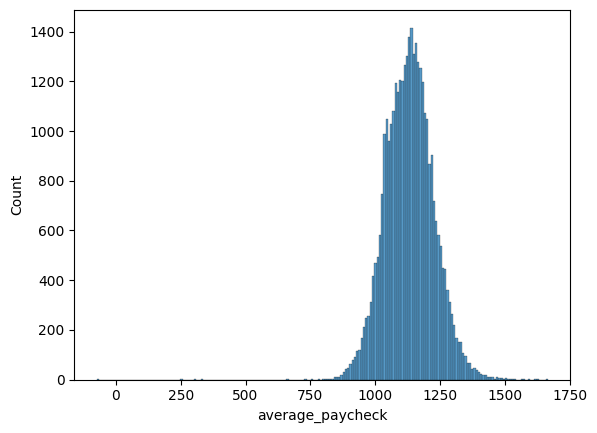

In [36]:
sns.histplot(data=ds, x="average_paycheck", bins=200)

Свяжем переменную menu_type со средней покупкой по аналогии с двумя предыдущими шагами

In [37]:
ds.loc[:,'menu_type'] = ds.menu_type.map(ds[ds.average_paycheck >= 1135].menu_type.value_counts())
ds

,id,address,is_holiday,day_type,season,comp_activity,M_promo_exp,M_promo_internet,M_promo_banners,S_price,M_price,menu_type,average_purchase_items,average_paycheck,repeated_customers_number,customers_number,M_sales,S_sales
1933,10111426.0,61.0,0.0,0.0,4235.0,28.0,26178.53131,28.0,4.0,229.0,309.0,2694.0,2.117005,962.616333,7.000000,289.0,244.442619,315.475353
2063,10111426.0,61.0,0.0,0.0,4269.0,0.0,26178.53131,28.0,4.0,349.0,389.0,3723.0,2.161360,1088.562997,9.000000,310.0,386.485300,230.443810
1882,10111426.0,61.0,0.0,1.0,4414.0,0.0,26178.53131,28.0,4.0,249.0,309.0,3511.0,2.416753,1202.652884,3.000000,279.0,365.490759,222.645867
1709,10111426.0,61.0,0.0,0.0,4325.0,0.0,68397.16823,12.0,59.0,349.0,319.0,3491.0,2.315531,1141.552587,7.000000,284.0,455.572552,225.245790
1999,10111426.0,61.0,0.0,0.0,4269.0,1.0,26178.53131,28.0,4.0,289.0,389.0,3723.0,1.964850,1219.096716,8.000000,294.0,353.934855,279.950969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509537,10112419.0,52.0,0.0,1.0,4325.0,0.0,68397.16823,12.0,59.0,349.0,319.0,3491.0,2.182818,1195.964861,1.000000,240.0,374.874855,207.878278
509855,10112419.0,52.0,0.0,1.0,4269.0,0.0,26178.53131,28.0,4.0,289.0,389.0,3723.0,2.129207,1232.379130,1.000000,249.0,361.715816,297.369286
461023,10112419.0,52.0,0.0,1.0,4414.0,0.0,26178.53131,28.0,4.0,279.0,309.0,3982.0,2.265965,1156.821734,2.000000,269.0,320.002865,225.588169
509865,10112419.0,52.0,0.0,0.0,4269.0,0.0,26178.53131,28.0,4.0,289.0,389.0,3723.0,2.452464,1222.346120,389.167959,293.0,413.851276,322.842728


### Нормализация

In [38]:
#не нормализую: id, address, is_holiday, day_type, comp_activity, т.к. это либо бинарные, либо небольшие дискретные значения
ds.reset_index(inplace=True, drop=True)
ds_1 = ds.loc[:,['id','address','is_holiday','day_type','comp_activity']]
ds_2 = ds.drop(columns=['id','address','is_holiday','day_type','comp_activity'],axis=1)
mms=MinMaxScaler()
mms.fit(ds_2)
ds_2_norm = pd.DataFrame(mms.transform(ds_2), columns=ds_2.columns)

In [39]:
ds_norm = pd.merge(ds_1, ds_2_norm, left_index=True, right_index=True)

Удалим переменную id из датафрейма (раньше она была коллинеарна адресу, а сейчас является единственной категориальной)

In [40]:
ds_norm.drop(columns='id', axis=1,inplace=True)

In [41]:
ds_norm

,address,is_holiday,day_type,comp_activity,season,M_promo_exp,M_promo_internet,M_promo_banners,S_price,M_price,menu_type,average_purchase_items,average_paycheck,repeated_customers_number,customers_number,M_sales,S_sales
0,61.0,0.0,0.0,28.0,0.000000,0.256818,0.080229,0.010283,0.653179,0.755501,0.000000,0.139626,0.595602,0.012625,0.496414,0.201902,0.682936
1,61.0,0.0,0.0,0.0,0.189944,0.256818,0.080229,0.010283,1.000000,0.951100,0.798913,0.145170,0.668032,0.016232,0.610127,0.468421,0.422421
2,61.0,0.0,1.0,0.0,1.000000,0.256818,0.080229,0.010283,0.710983,0.755501,0.634317,0.177094,0.733643,0.005411,0.442265,0.429028,0.398530
3,61.0,0.0,0.0,0.0,0.502793,0.670992,0.034384,0.151671,1.000000,0.779951,0.618789,0.164441,0.698505,0.012625,0.469339,0.598051,0.406495
4,61.0,0.0,0.0,1.0,0.189944,0.256818,0.080229,0.010283,0.826590,0.951100,0.798913,0.120606,0.743099,0.014428,0.523488,0.407346,0.574098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35691,52.0,0.0,1.0,0.0,0.502793,0.670992,0.034384,0.151671,1.000000,0.779951,0.618789,0.147852,0.729797,0.001804,0.231084,0.446636,0.353286
35692,52.0,0.0,1.0,0.0,0.189944,0.256818,0.080229,0.010283,0.826590,0.951100,0.798913,0.141151,0.750738,0.001804,0.279818,0.421945,0.627464
35693,52.0,0.0,1.0,0.0,1.000000,0.256818,0.080229,0.010283,0.797688,0.755501,1.000000,0.158246,0.707286,0.003607,0.388116,0.343678,0.407544
35694,52.0,0.0,0.0,0.0,0.189944,0.256818,0.080229,0.010283,0.826590,0.951100,0.798913,0.181558,0.744968,0.701879,0.518074,0.519768,0.705508


### Построение графа

In [42]:
# укладка графа
pos = {'address':(1.5,4), 'is_holiday':(7, 12), 'day_type':(13, 4), 'season':(2, 7), 'comp_activity':(2.5, 12),
       'M_promo_exp':(7, 1), 'M_promo_internet':(3.5, 2.5), 'M_promo_banners':(2, 5.1), 'S_price':(5, 12), 'M_price':(9.5, 3), 'menu_type':(7.2,5.5), 
       'average_purchase_items':(7, 8),'average_paycheck':(1, 10),'repeated_customers_number':(12.2,7.2), 'customers_number':(11.3, 2.5), 
       'M_sales':(11, 9), 'S_sales':(9.5, 10.5)}
#вершины
nodes = list(ds_norm.columns)

In [43]:
graph_pc_raw = pc(ds_norm.values, alpha=alpha, indep_test='fisherz')

Depth=9, working on node 16: 100%|██████████| 17/17 [00:00<00:00, 293.11it/s]


In [44]:
graph_pc_raw.to_nx_graph()

mapping = {node:i for node, i in enumerate(ds_norm.columns)}
mapping_r = {i:node for node, i in enumerate(ds_norm.columns)}

graph_pc = nx.relabel_nodes(graph_pc_raw.nx_graph, mapping)

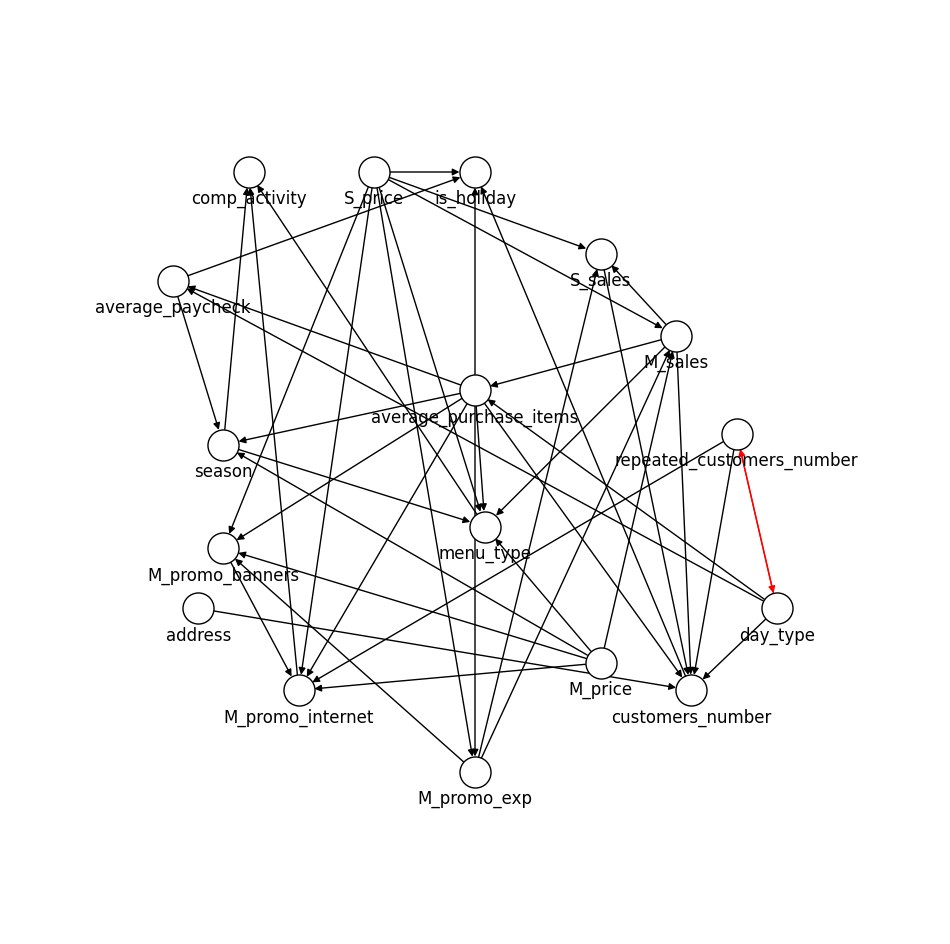

In [45]:
draw_graph(graph_pc, pos)

In [46]:
backgroung_knowledge = BackgroundKnowledge()
nodes = graph_pc_raw.G.get_nodes()

node_from = nodes[mapping_r['average_paycheck']]
node_to = nodes[mapping_r['season']]
backgroung_knowledge.add_forbidden_by_node(node_from, node_to)

# полностью удаляем ребро из графа
#node_from = nodes[mapping_r['comp_activity']]
#node_to = nodes[mapping_r['menu_type']]

#backgroung_knowledge.add_forbidden_by_node(node_from, node_to)
#backgroung_knowledge.add_forbidden_by_node(node_to, node_from)

# строим граф с учётом внесённых изменений
graph_pc_raw_bk = pc(ds_norm.values, alpha=alpha, indep_test='fisherz', background_knowledge=backgroung_knowledge)

graph_pc_raw_bk.to_nx_graph()

# добавим корректные названия вершин в граф
graph_pc_bk = nx.relabel_nodes(graph_pc_raw_bk.nx_graph, mapping)

Depth=9, working on node 16: 100%|██████████| 17/17 [00:00<00:00, 293.10it/s]


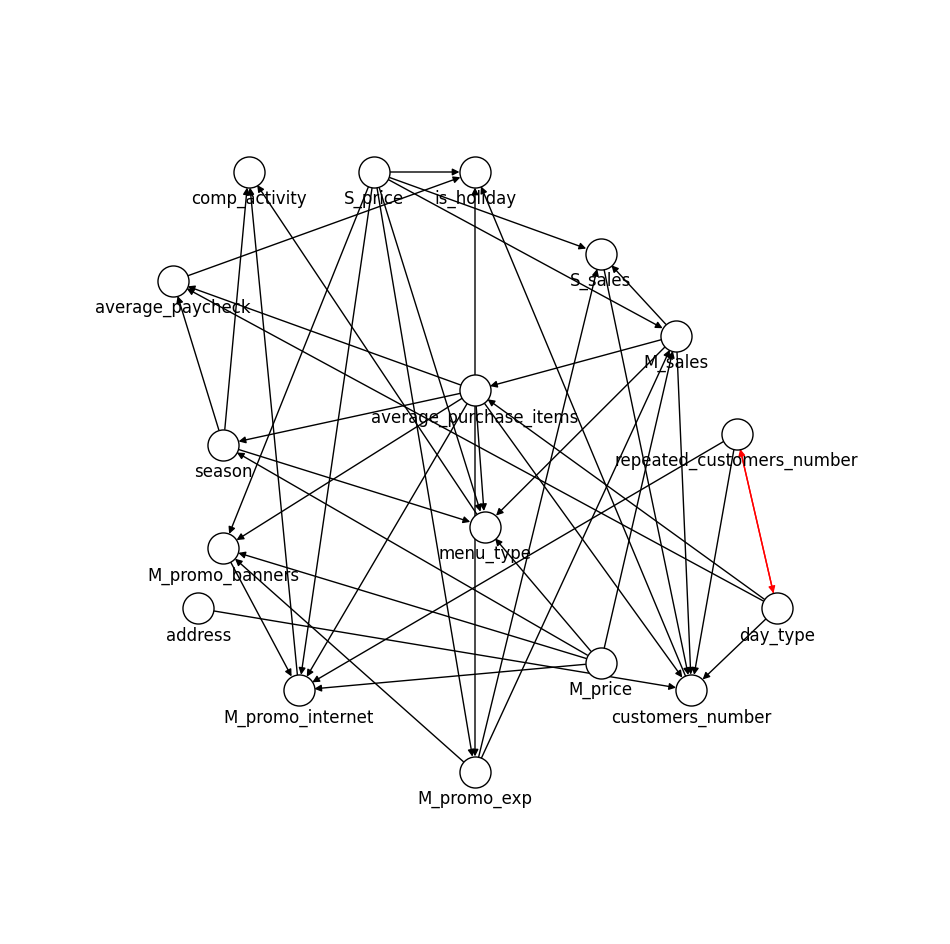

In [47]:
draw_graph(graph_pc_bk, pos)